In [107]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F

from torch.utils.tensorboard import SummaryWriter

In [108]:
writer = SummaryWriter("runs/mnist2")

# device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# hyperparamters
input_size = 28*28
hidden_size = 100
num_classes = 10
num_epochs = 2
learning_rate = 0.001
batch_size = 100

In [109]:
# MNIST
train_dataset = torchvision.datasets.MNIST(root='./data/FeedForward', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='./data/FeedForward', train=False, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

examples = iter(train_loader)
samples, labels = next(examples)
print(samples.shape, labels.shape)

torch.Size([100, 1, 28, 28]) torch.Size([100])


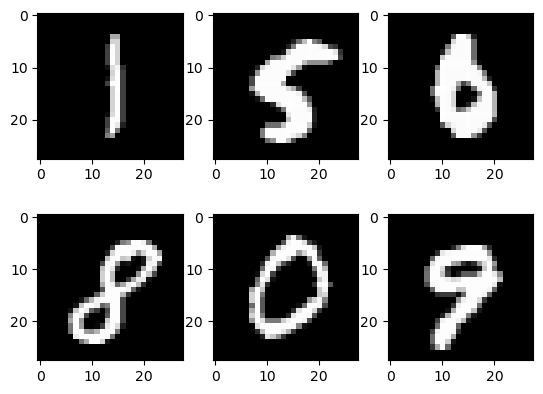

In [110]:
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(samples[i][0], cmap='gray')
    
# Add images of data to TensorBoard
img_grid = torchvision.utils.make_grid(samples)
writer.add_image('mnist_images', img_grid)

In [111]:
class NeuralNet(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        return out

In [112]:
model = NeuralNet(input_size, hidden_size, num_classes)
model.to(device)

NeuralNet(
  (l1): Linear(in_features=784, out_features=100, bias=True)
  (relu): ReLU()
  (l2): Linear(in_features=100, out_features=10, bias=True)
)

In [113]:
# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# Add graph of model to TensorBoard
writer.add_graph(model, samples.reshape(-1, 28*28).to(device))

In [114]:
# training loop
n_total_steps = len(train_loader)

running_loss = 0
running_correct = 0

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        
        # forward
        outputs = model(images)
        
        # loss
        loss = criterion(outputs, labels)
        
        # backprop
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        running_loss += loss.item()
        _, preds = torch.max(outputs, axis=1)
        running_correct += ((preds == labels).sum().item() / batch_size)
        
        if (i) % 100 == 0:
            print(f'epoch: {epoch+1}, / {num_epochs}, step {i+1}/{n_total_steps}, loss = {loss.item():.4f}')
            writer.add_scalar('Training Loss', running_loss / 100, epoch * n_total_steps + i)
            writer.add_scalar('Training Accuracy', running_correct / 100, epoch * n_total_steps + i)
            running_loss, running_correct = 0, 0

epoch: 1, / 2, step 1/600, loss = 2.3130
epoch: 1, / 2, step 101/600, loss = 0.3595
epoch: 1, / 2, step 201/600, loss = 0.4039
epoch: 1, / 2, step 301/600, loss = 0.2034
epoch: 1, / 2, step 401/600, loss = 0.1730
epoch: 1, / 2, step 501/600, loss = 0.2295
epoch: 2, / 2, step 1/600, loss = 0.1031
epoch: 2, / 2, step 101/600, loss = 0.1390
epoch: 2, / 2, step 201/600, loss = 0.1251
epoch: 2, / 2, step 301/600, loss = 0.1561
epoch: 2, / 2, step 401/600, loss = 0.1795
epoch: 2, / 2, step 501/600, loss = 0.2564


In [120]:
# evaluation
labels_lst = []
predictions = []
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        
        # value, index
        _, preds = torch.max(outputs, axis=1)
        n_samples += labels.shape[0]
        n_correct += (preds == labels).sum().item()
        
        class_preds = [F.softmax(output, dim=0) for output in outputs]
        
        labels_lst.append(labels)
        predictions.append(class_preds)
        
    predictions = torch.cat([torch.stack(batch) for batch in predictions])
    labels_lst = torch.cat(labels_lst)
        
    acc = 100 * (n_correct / n_samples)
    print("Accuracy = ", acc)
    
    classes = range(10)
    for i in classes:
        labels_i = labels_lst == i
        preds_i = predictions[:, i]
        writer.add_pr_curve(str(i), labels_i, preds_i, global_step=0)
        writer.close()

Accuracy =  95.42
